# RNN -> LSTM
### 5 features
### 5 timesteps
### Evaluated by MSE 

In [5]:
from __future__ import print_function
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tensorflow as tf
import sklearn as sk
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt

In [6]:
def select_columns(col_list, n_months):
    
    """takes in a list of column names and number of visits starting at 0
    returns column list time-stepped and dovetailed""" 
    
    return dovetail_names(*[time_step_names(i, n_months) for i in col_list])
        
def time_step_names(name, n_months):

    return [(name + '_%d' % (j+1)) for j in range(-1,n_months*6, 6)]

def dovetail_names(*kwargs):
    zipped = zip(*kwargs)
    l = []
    for i in zipped:
        for j in i:
            l.append(j)
    return l

# Filter Data

In [7]:
col_names_raw = ['ATTACK','PYRAMIDAL_FUNCTION','CEREBELLAR_FUNCTION','BRAINSTEM_FUNCTION','EDSS']
n = 5
col_names = select_columns(col_names_raw, n)
dataset = pd.read_csv("df_by_subject_November_6.csv")
df = dataset[col_names]

n_inputs = len(col_names_raw)
batch_size = 5
time_steps = 5

# Fill in Missing Values

In [8]:
df = dataset[col_names]

"""CONTINUOUS"""
# Z-score mask EDSS
for col in select_columns(['EDSS'],n):
    df.loc[: ,col].fillna(df.loc[: ,col].dropna().mode()[0], inplace=True)

"""BINARY CATEGORICAL"""
# Replace Q and N as NaN, Nan with mode
for col in select_columns(['ATTACK'],n):
    df.loc[: ,col].replace(['Q','N'], np.NaN, inplace=True)
    df.loc[: ,col].fillna(df.loc[: ,col].dropna().mode()[0], inplace=True)

"""MULTICLASS CATEGORICAL"""
# Replace X with NaN, NaNs with mode
for col in select_columns(['CEREBELLAR_FUNCTION'],n):
    df.loc[: ,col].replace('X', np.NaN, inplace=True) 
    df.loc[: ,col].fillna(df.loc[: ,col].dropna().mode()[0], inplace=True)

# Replace NaNs with mode
for col in select_columns(['PYRAMIDAL_FUNCTION'],n):
    df.loc[: ,col].fillna(df.loc[: ,col].dropna().mode()[0], inplace=True)
    
# Replace X with NaN, NaNs with mode
for col in select_columns(['BRAINSTEM_FUNCTION'],n):
    df.loc[: ,col].replace('X', np.NaN, inplace=True) 
    df.loc[: ,col].fillna(df.loc[: ,col].dropna().mode()[0], inplace=True)

/Users/matiasberretta/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/matiasberretta/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5886: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


# Reshaping Data into RNN friendly shape

In [10]:
rows = 508
X = df.iloc[:rows,:25].copy()
#y = df.loc[:, select_columns(['EDSS'], n)].iloc[:15,1:].values
y = df[select_columns(['EDSS'], 5)].drop('EDSS_0', axis = 1).iloc[:rows]
print(X.shape, y.shape) 

(508, 25) (508, 5)


# Split into train and test

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [14]:
X_train_reshaped = X_train.values.reshape(-1, time_steps, n_inputs)
y_train_reshaped = y_train.values.reshape(-1, time_steps, 1)
print("X reshaped is " + str(X_train_reshaped.shape))
print("y reshaped is " + str(y_train_reshaped.shape))

X reshaped is (406, 5, 5)
y reshaped is (406, 5, 1)


In [15]:
X_test_reshaped = X_test.values.reshape(-1, time_steps, n_inputs)
y_test_reshaped = y_test.values.reshape(-1, time_steps, 1)
print("X reshaped is " + str(X_test_reshaped.shape))
print("y reshaped is " + str(y_test_reshaped.shape))

X reshaped is (102, 5, 5)
y reshaped is (102, 5, 1)


In [16]:
n_inputs = 5 # 27 features + 38 fixed features 

n_neurons = 15

n_layers = 1

n_outputs = 1

learning_rate = 0.001

n_steps = 5 # 5 steps 

In [21]:
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs], name = "X") # [None, 5, 27]
y = tf.placeholder(tf.int32, [None, n_steps, 1], name = "y") # changed from tf.float32 to tf.int32 

In [22]:
layers = [tf.contrib.rnn.BasicRNNCell(num_units = n_neurons, activation = tf.nn.relu)for layer in range(n_layers)]

In [23]:
lstm_cell = tf.contrib.rnn.LSTMCell(num_units = n_neurons, use_peepholes = True)
output_seqs, (c_states, h_states) = tf.nn.dynamic_rnn(lstm_cell, X, dtype = tf.float32)

In [24]:
predictions = tf.contrib.layers.fully_connected(output_seqs, 1, activation_fn=tf.sigmoid)

In [25]:
loss = tf.losses.mean_squared_error(labels = y, predictions = predictions)

In [26]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
training_op = optimizer.minimize(loss)

In [30]:
init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
X_train = X_train_reshaped
y_train = y_train_reshaped
X_test= X_test_reshaped
y_test = y_test_reshaped

In [38]:
n_epochs = 20
batch_sz = 50
#train_keep_prob = 0.5
mse_train = []

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iter in range(len(X_train) // batch_sz):

            X_batch, y_batch = X_train[iter*batch_sz: (iter+1)*batch_sz], y_train[iter*batch_sz: (iter+1)*batch_sz]
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            y_batch = y_batch.reshape((-1,5, 1)) # added 1
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            
        mse_train.append(sess.run(loss, feed_dict={X: X_batch, y: y_batch}))

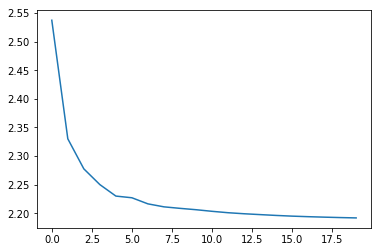

In [39]:
plt.plot(mse_train)

In [32]:
n_epochs = 20
batch_sz = 50
#train_keep_prob = 0.5
mse_test = []

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iter in range(len(X_test) // batch_sz):

            X_batch, y_batch = X_test[iter*batch_sz: (iter+1)*batch_sz], y_test[iter*batch_sz: (iter+1)*batch_sz]
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            y_batch = y_batch.reshape((-1,5, 1)) # added 1
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            
        mse_test.append(sess.run(loss, feed_dict={X: X_batch, y: y_batch}))

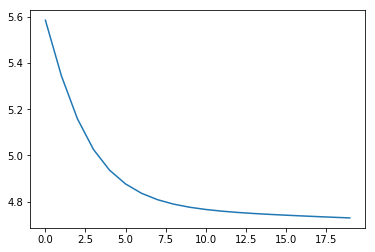

In [35]:
plt.plot(mse_test)

In [45]:
print("Train MSE:", mse_train[-1], "Test MSE:", mse_test[-1])

Train MSE: 2.1918697 Test MSE: 4.729342
